##**Package loading**

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import GradScaler, autocast


##**Mount to Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir="/content/drive/MyDrive/University/U_Third/Winter term/APS360/APS360 Project/APS360 Process Report Dataset/train"
val_dir="/content/drive/MyDrive/University/U_Third/Winter term/APS360/APS360 Project/APS360 Process Report Dataset/val"
test_dir="/content/drive/MyDrive/University/U_Third/Winter term/APS360/APS360 Project/APS360 Process Report Dataset/test"
test_dir_our="/content/drive/MyDrive/University/U_Third/Winter term/APS360/APS360 Project/Create Your Own Test Set"

##**Load the data**

In [ ]:
torch.manual_seed(1)

#Data agumentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # VGG16 expects 224x224 inputs
    transforms.RandomHorizontalFlip(),  # Simple augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

# Load datasets:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
# Set up data loaders:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  #Shuffle is to ensure the model isn’t adapting its learning to any kind of spurious pattern


# Define transformations and normalization for your images:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the VGG model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
# Set up data loaders:
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


##**Check the labels of the train dataset**

In [ ]:
# Check labels for one batch of the training data
for images, labels in train_loader:
    print("Labels for one batch:", labels)
    print("Class names for one batch:", [list(train_dataset.class_to_idx.keys())[list(train_dataset.class_to_idx.values()).index(label)] for label in labels])
    break  # Only look at the first batch


Labels for one batch: tensor([1, 3, 1, 1, 2, 0, 2, 0, 3, 2, 0, 2, 0, 1, 0, 1, 0, 1, 3, 3, 0, 1, 0, 1,
        2, 0, 0, 2, 2, 3, 3, 3])
Class names for one batch: ['organics', 'trash', 'organics', 'organics', 'recycle', 'hazardous', 'recycle', 'hazardous', 'trash', 'recycle', 'hazardous', 'recycle', 'hazardous', 'organics', 'hazardous', 'organics', 'hazardous', 'organics', 'trash', 'trash', 'hazardous', 'organics', 'hazardous', 'organics', 'recycle', 'hazardous', 'hazardous', 'recycle', 'recycle', 'trash', 'trash', 'trash']


##**Check labels for the validation data**

In [ ]:
for images, labels in validation_loader:
     print("Labels for one batch:", labels)
     print("Class names for one batch:", [list(val_dataset.class_to_idx.keys())[list(val_dataset.class_to_idx.values()).index(label)] for label in labels])
     break # Only look at the first batch


Labels for one batch: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Class names for one batch: ['hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous', 'hazardous']


##**Buildup the arichitecture**

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=4):  # Categories=['trash','recycle','organics', 'hazardous']
        super(VGG16, self).__init__()
        self.name= "VGG16"
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

# Instantiate the model
vgg16 = VGG16(num_classes=4)  # four classes

# Print the model architecture
print(vgg16)


VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

#**Pretrained original VGG-16**

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=4):  # Number of classes
        super(VGG16, self).__init__()
        # Load the pre-trained VGG16 model
        original_vgg16 = models.vgg16(pretrained=True)

        # Freeze the features layers (optional, remove these lines if you want to fine-tune the convolutional layers)
        for param in original_vgg16.features.parameters():
            param.requires_grad = False

        # Replace the classifier with a new one for 4 classes
        # Note: The input features of the first linear layer of the classifier might need adjustment based on the pre-trained model
        num_features = original_vgg16.classifier[0].in_features
        original_vgg16.classifier = nn.Sequential(
            nn.Linear(num_features, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        self.features = original_vgg16.features
        self.classifier = original_vgg16.classifier

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output of conv layers
        x = self.classifier(x)
        return x

# Instantiate the model
vgg16 = VGG16(num_classes=4)  # Assuming you have four classes

# Print the modified model architecture
print(vgg16)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

##**Set up the loss function and  Optimizer**

In [ ]:
# For multi-class classification
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)  # default learning rate

#device should be defined based on system's configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

#**Training**

Changes: learning_rate is now managed by the optimizer and scheduler outside the function, and batch_size is determined by the DataLoader.
Mixed precision training can speed up training times significantly and allow for larger batch sizes without sacrificing accuracy. PyTorch supports mixed precision via its torch.cuda.amp module

In [ ]:
def train(model, train_loader, validation_loader, num_epochs, optimizer, scheduler=None):
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Initialize the gradient scaler for mixed precision
    scaler = GradScaler()
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        total_train, correct_train, running_loss = 0, 0, 0.0
        train_preds, train_targets = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            running_loss += loss.item() * inputs.size(0)
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        train_f1 = f1_score(train_targets, train_preds, average='weighted')

        if scheduler:
            scheduler.step()  # Adjust the learning rate after each epoch

        # Validation Phase
        model.eval()
        val_running_loss, total_val, correct_val = 0.0, 0, 0
        val_preds, val_targets = [], []
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(validation_loader.dataset)
        val_accuracy = 100 * correct_val / total_val
        val_f1 = f1_score(val_targets, val_preds, average='weighted')


        #store the result of accuracy, loss
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        # Print both training and validation metrics
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}%, F1-Score: {train_f1:.4f}')
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}%, F1-Score: {val_f1:.4f}\n')

    #Making the plot
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()


#**Tunning stage**

##**First Tunning**

Epoch 1/15
Training Loss: 3.0798, Accuracy: 60.5000%, F1-Score: 0.6057
Validation Loss: 0.6511, Accuracy: 80.0000%, F1-Score: 0.7985

Epoch 2/15
Training Loss: 0.6137, Accuracy: 83.3333%, F1-Score: 0.8325
Validation Loss: 0.2874, Accuracy: 90.0000%, F1-Score: 0.9001

Epoch 3/15
Training Loss: 0.3889, Accuracy: 85.8333%, F1-Score: 0.8595
Validation Loss: 0.2479, Accuracy: 90.0000%, F1-Score: 0.9032

Epoch 4/15
Training Loss: 0.3763, Accuracy: 87.0000%, F1-Score: 0.8703
Validation Loss: 0.4224, Accuracy: 84.5000%, F1-Score: 0.8474

Epoch 5/15
Training Loss: 0.3022, Accuracy: 90.0000%, F1-Score: 0.8995
Validation Loss: 0.3409, Accuracy: 89.5000%, F1-Score: 0.8963

Epoch 6/15
Training Loss: 0.1637, Accuracy: 94.0000%, F1-Score: 0.9403
Validation Loss: 0.3410, Accuracy: 89.5000%, F1-Score: 0.8963

Epoch 7/15
Training Loss: 0.1787, Accuracy: 94.3333%, F1-Score: 0.9439
Validation Loss: 0.3407, Accuracy: 89.5000%, F1-Score: 0.8963

Epoch 8/15
Training Loss: 0.1976, Accuracy: 93.6667%, F1-Score

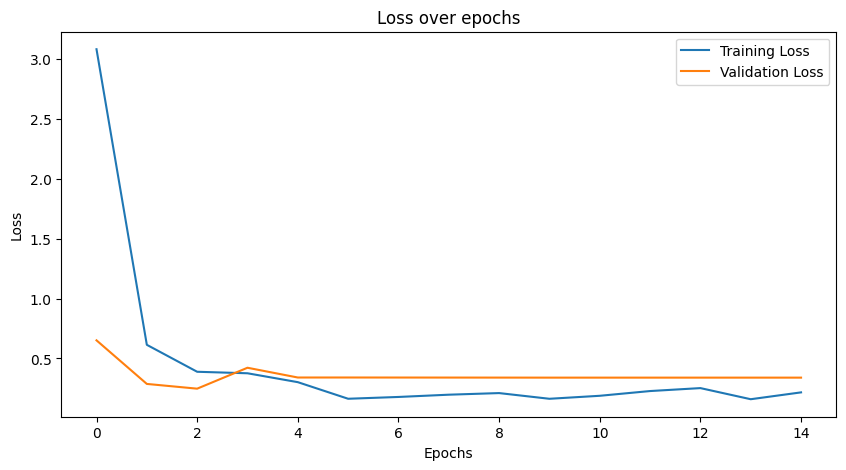

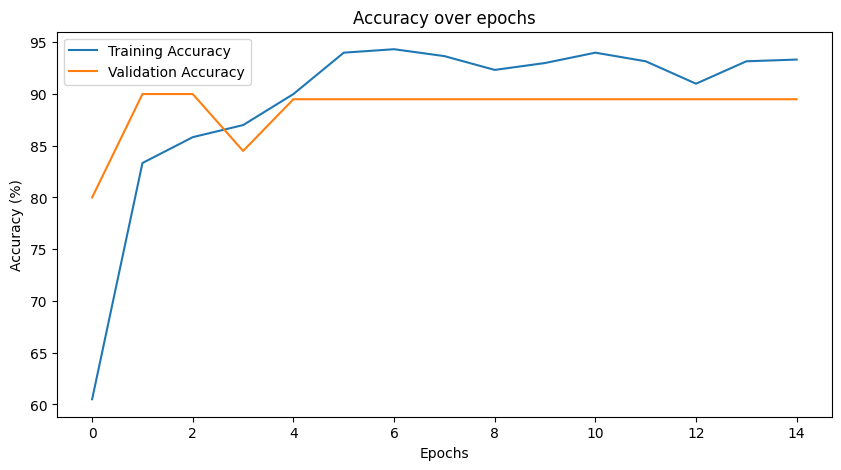

In [ ]:
# Train the model
#default learning rate=0.001 (admin optimizer), batch size=32(dataloder)
# Adjusts the learning rate every 10 epochs by multiplying it by 0.001,
scheduler = StepLR(optimizer, step_size=5, gamma=0.0001)
train(vgg16, train_loader, validation_loader, num_epochs=15, optimizer=optimizer, scheduler=scheduler)

analysis:
starting from Epoch 4, while  training metrics continue to improve, validation loss stabilizes and validation accuracy and F1-score remain constant. This pattern suggests a few potential scenarios to consider:  Early Convergence on Validation Data,

##**Second Tunning**

Epoch 1/20
Training Loss: 69.5715, Accuracy: 49.0000%, F1-Score: 0.4762
Validation Loss: 2.1793, Accuracy: 78.0000%, F1-Score: 0.7742

Epoch 2/20
Training Loss: 7.7464, Accuracy: 72.6667%, F1-Score: 0.7257
Validation Loss: 7.2678, Accuracy: 86.0000%, F1-Score: 0.8648

Epoch 3/20
Training Loss: 16.7309, Accuracy: 74.8333%, F1-Score: 0.7483
Validation Loss: 9.3505, Accuracy: 87.5000%, F1-Score: 0.8718

Epoch 4/20
Training Loss: 26.4247, Accuracy: 76.8333%, F1-Score: 0.7681
Validation Loss: 9.4819, Accuracy: 77.5000%, F1-Score: 0.7600

Epoch 5/20
Training Loss: 21.6735, Accuracy: 76.3333%, F1-Score: 0.7603
Validation Loss: 15.1986, Accuracy: 82.0000%, F1-Score: 0.8252

Epoch 6/20
Training Loss: 28.3773, Accuracy: 81.1667%, F1-Score: 0.8122
Validation Loss: 13.7753, Accuracy: 84.0000%, F1-Score: 0.8459

Epoch 7/20
Training Loss: 38.1974, Accuracy: 80.8333%, F1-Score: 0.8080
Validation Loss: 20.5386, Accuracy: 82.5000%, F1-Score: 0.8075

Epoch 8/20
Training Loss: 48.4685, Accuracy: 80.3333%

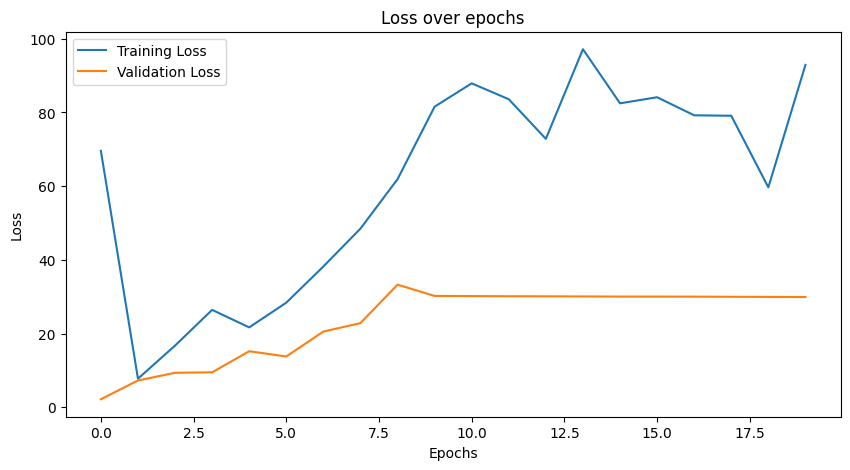

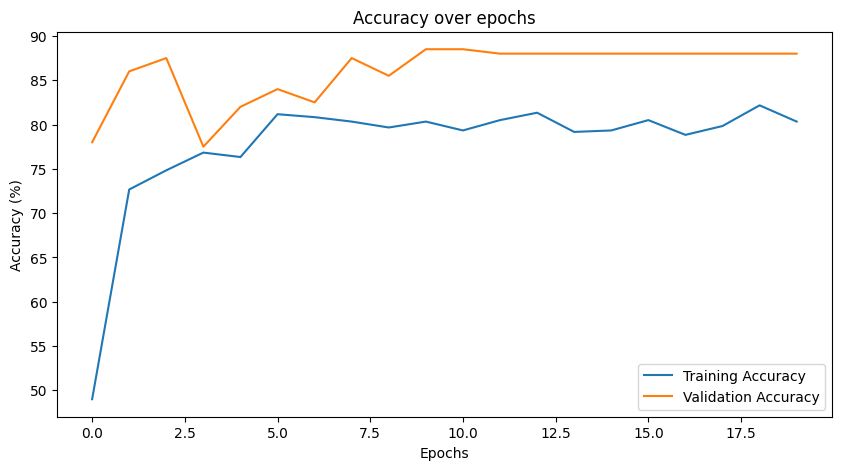

In [ ]:
#Change the optimizer learning rate to be 0.01, batch size is still 32
optimizer = optim.Adam(vgg16.parameters(), lr=0.01)  # default learning rate
# Adjusts the learning rate every 10 epochs by multiplying it by 0.0001
scheduler = StepLR(optimizer, step_size=10, gamma=0.0001)
train(vgg16, train_loader, validation_loader, num_epochs=20, optimizer=optimizer, scheduler=scheduler)

analysis: Fluctucating traininng loss, it may be overfitting, the training set may reached its learning capacity given the current architecture. The validation loss increases indicates that the model is becoing more confident in its incorrect predictions, this is may also indicate the potential overfitting

##**Third Tunning**

In [ ]:
#Change the batchsize to see if it is helpful=  32--->45
torch.manual_seed(1)

#Data agumentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # VGG16 expects 224x224 inputs
    transforms.RandomHorizontalFlip(),  # Simple augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

# Load datasets:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
# Set up data loaders:
train_loader = DataLoader(train_dataset, batch_size=45, shuffle=True)  #Shuffle is to ensure the model isn’t adapting its learning to any kind of spurious pattern


# Define transformations and normalization for your images:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the VGG model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
# Set up data loaders:
validation_loader = DataLoader(val_dataset, batch_size=45, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=45, shuffle=False)


Epoch 1/20
Training Loss: 88.5238, Accuracy: 80.3333%, F1-Score: 0.8046
Validation Loss: 26.6634, Accuracy: 87.5000%, F1-Score: 0.8721

Epoch 2/20
Training Loss: 60.8764, Accuracy: 82.6667%, F1-Score: 0.8265
Validation Loss: 19.0244, Accuracy: 87.5000%, F1-Score: 0.8761

Epoch 3/20
Training Loss: 43.4736, Accuracy: 83.6667%, F1-Score: 0.8360
Validation Loss: 19.0951, Accuracy: 87.0000%, F1-Score: 0.8647

Epoch 4/20
Training Loss: 41.0388, Accuracy: 83.6667%, F1-Score: 0.8357
Validation Loss: 8.5581, Accuracy: 94.5000%, F1-Score: 0.9455

Epoch 5/20
Training Loss: 38.1119, Accuracy: 86.0000%, F1-Score: 0.8593
Validation Loss: 5.6370, Accuracy: 93.5000%, F1-Score: 0.9355

Epoch 6/20
Training Loss: 28.1963, Accuracy: 87.0000%, F1-Score: 0.8703
Validation Loss: 17.3744, Accuracy: 88.5000%, F1-Score: 0.8829

Epoch 7/20
Training Loss: 43.3614, Accuracy: 85.8333%, F1-Score: 0.8581
Validation Loss: 12.5180, Accuracy: 94.0000%, F1-Score: 0.9402

Epoch 8/20
Training Loss: 42.9305, Accuracy: 86.50

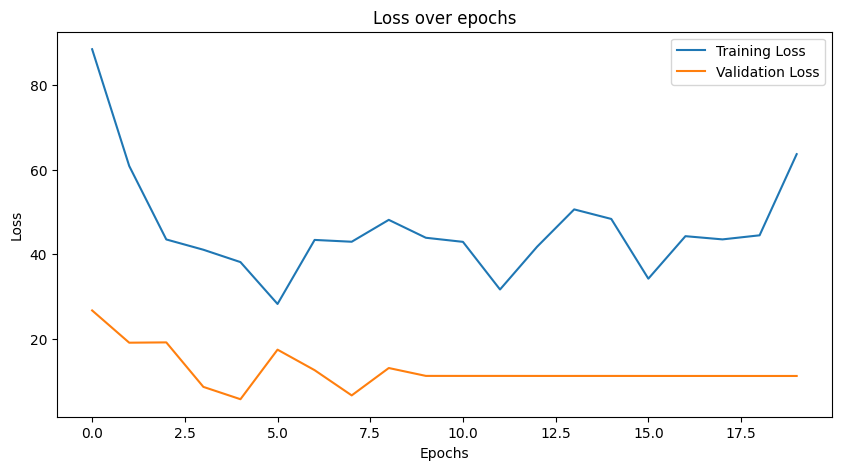

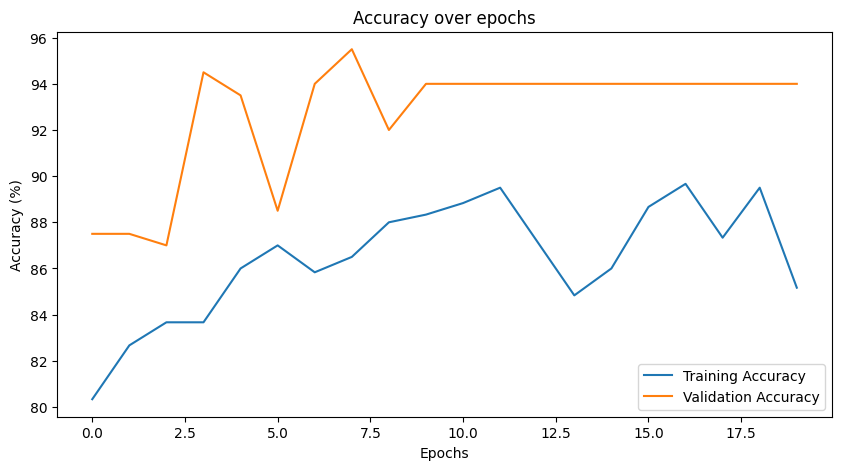

In [ ]:
#Change the optimizer learning rate to be 0.01, batch size is 45 here
optimizer = optim.Adam(vgg16.parameters(), lr=0.01)  # default learning rate
# Adjusts the learning rate every 10 epochs by multiplying it by 0.0001
scheduler = StepLR(optimizer, step_size=10, gamma=0.0001)
train(vgg16, train_loader, validation_loader, num_epochs=20, optimizer=optimizer, scheduler=scheduler)

analysis:Looking at the loss graph, the validation loss generally trends below the training loss, which is somewhat unusual we expect the training loss to be lower than the validation loss, as the model is directly learning from the training data. If the validation loss is consistently lower, it might indicate that the validation set is easier for the model to predict,For the accuracy graph, there is a noticeable gap between the training and validation accuracy, with the validation accuracy being higher. This again is atypical since models usually perform better on the data they were trained on.

##**Fourth Tunning**

In [ ]:
#Change the batchsize to see if it is helpful=  32--->60
torch.manual_seed(1)

#Data agumentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # VGG16 expects 224x224 inputs
    transforms.RandomHorizontalFlip(),  # Simple augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

# Load datasets:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
# Set up data loaders:
train_loader = DataLoader(train_dataset, batch_size=60, shuffle=True)  #Shuffle is to ensure the model isn’t adapting its learning to any kind of spurious pattern


# Define transformations and normalization for your images:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the VGG model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
# Set up data loaders:
validation_loader = DataLoader(val_dataset, batch_size=60, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=60, shuffle=False)


Epoch 1/15
Training Loss: 6.6835, Accuracy: 37.1667%, F1-Score: 0.3746
Validation Loss: 0.9433, Accuracy: 58.0000%, F1-Score: 0.5254

Epoch 2/15
Training Loss: 0.7576, Accuracy: 71.5000%, F1-Score: 0.7136
Validation Loss: 0.2446, Accuracy: 90.0000%, F1-Score: 0.9001

Epoch 3/15
Training Loss: 0.4285, Accuracy: 86.3333%, F1-Score: 0.8632
Validation Loss: 0.2452, Accuracy: 91.5000%, F1-Score: 0.9140

Epoch 4/15
Training Loss: 0.3169, Accuracy: 88.5000%, F1-Score: 0.8853
Validation Loss: 0.3838, Accuracy: 86.5000%, F1-Score: 0.8664

Epoch 5/15
Training Loss: 0.2472, Accuracy: 90.6667%, F1-Score: 0.9066
Validation Loss: 0.1441, Accuracy: 94.0000%, F1-Score: 0.9407

Epoch 6/15
Training Loss: 0.2086, Accuracy: 92.8333%, F1-Score: 0.9286
Validation Loss: 0.1998, Accuracy: 93.0000%, F1-Score: 0.9309

Epoch 7/15
Training Loss: 0.1918, Accuracy: 92.8333%, F1-Score: 0.9285
Validation Loss: 0.1460, Accuracy: 93.5000%, F1-Score: 0.9354

Epoch 8/15
Training Loss: 0.1969, Accuracy: 92.1667%, F1-Score

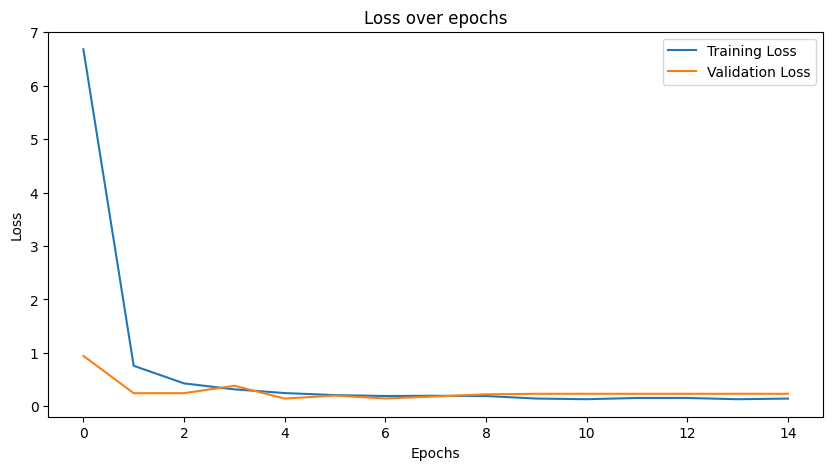

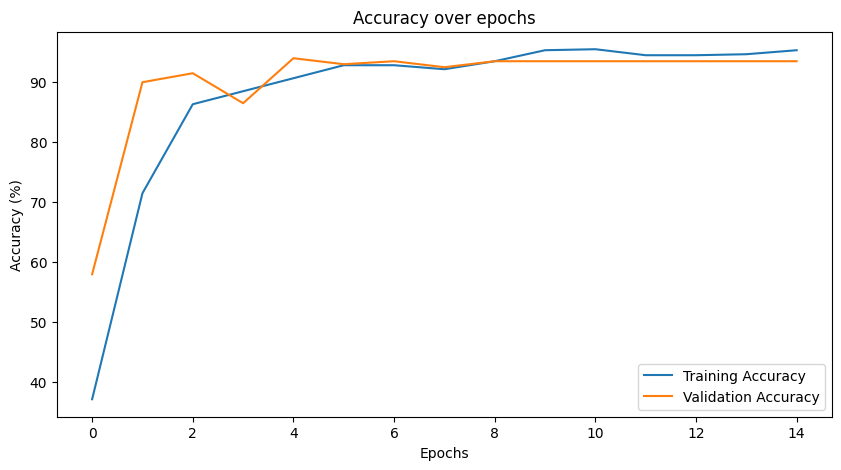

In [ ]:
#Change the optimizer learning rate to be 0.001, batch size is 60 here
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)  # default learning rate
# Adjusts the learning rate every 10 epochs by multiplying it by 0.0001
scheduler = StepLR(optimizer, step_size=10, gamma=0.0001)
train(vgg16, train_loader, validation_loader, num_epochs=15, optimizer=optimizer, scheduler=scheduler)

Analysis: From Epoch 4 onwards, both the training and validation metrics improve and stabilize. The validation loss and accuracy remain constant after a certain point, which could be a cue for early stopping, In summary, the signs are generally positive regarding model convergence, but the better performance on the validation set compared to the training set is unusual and warrants investigation into the data and how it’s being split and used.. This may due to the data agumentation

##**Fifth Tunning**

In [ ]:
#Change the batchsize to see if it is helpful=  32--->60 and remove the data agumentation
torch.manual_seed(1)

# Define transformations and normalization for your images:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the VGG model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])

# Load datasets:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
# Set up data loaders:
train_loader = DataLoader(train_dataset, batch_size=60, shuffle=True)  #Shuffle is to ensure the model isn’t adapting its learning to any kind of spurious pattern

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
# Set up data loaders:
validation_loader = DataLoader(val_dataset, batch_size=60, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=60, shuffle=False)

Epoch 1/15
Training Loss: 10.2637, Accuracy: 34.5000%, F1-Score: 0.3422
Validation Loss: 0.6691, Accuracy: 77.5000%, F1-Score: 0.7693

Epoch 2/15
Training Loss: 0.5961, Accuracy: 81.8333%, F1-Score: 0.8170
Validation Loss: 0.2300, Accuracy: 91.5000%, F1-Score: 0.9167

Epoch 3/15
Training Loss: 0.1482, Accuracy: 95.5000%, F1-Score: 0.9549
Validation Loss: 0.1914, Accuracy: 92.5000%, F1-Score: 0.9264

Epoch 4/15
Training Loss: 0.0542, Accuracy: 98.0000%, F1-Score: 0.9799
Validation Loss: 0.3827, Accuracy: 91.5000%, F1-Score: 0.9145

Epoch 5/15
Training Loss: 0.0249, Accuracy: 98.6667%, F1-Score: 0.9866
Validation Loss: 0.2944, Accuracy: 93.0000%, F1-Score: 0.9304

Epoch 6/15
Training Loss: 0.0013, Accuracy: 100.0000%, F1-Score: 1.0000
Validation Loss: 0.1983, Accuracy: 93.5000%, F1-Score: 0.9350

Epoch 7/15
Training Loss: 0.0096, Accuracy: 99.6667%, F1-Score: 0.9967
Validation Loss: 0.2071, Accuracy: 94.0000%, F1-Score: 0.9407

Epoch 8/15
Training Loss: 0.0135, Accuracy: 99.6667%, F1-Sco

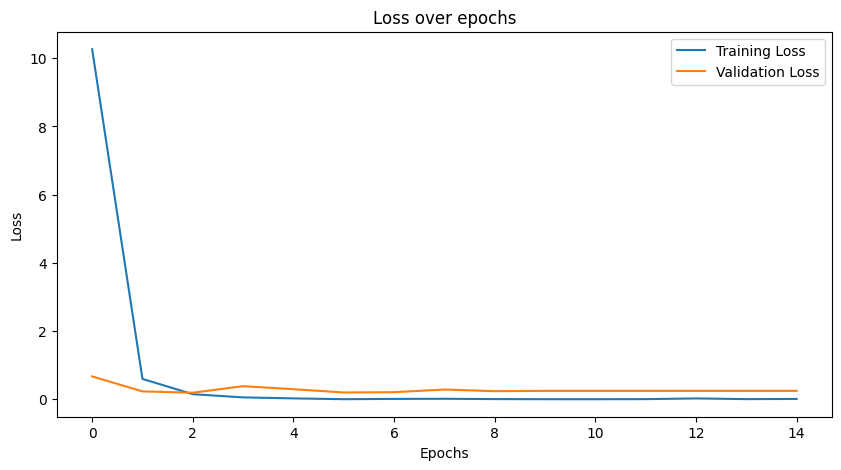

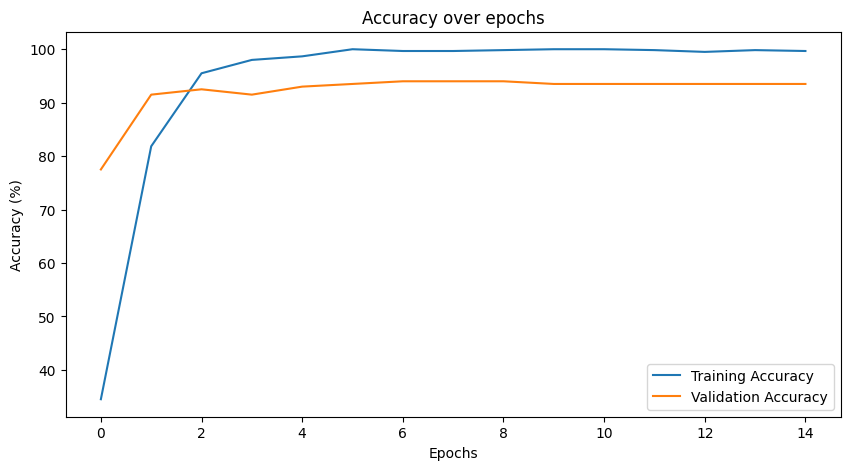

In [ ]:
#Change the optimizer learning rate to be 0.001, batch size is 60 here
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)  # default learning rate
# Adjusts the learning rate every 10 epochs by multiplying it by 0.0001
scheduler = StepLR(optimizer, step_size=10, gamma=0.0001)
train(vgg16, train_loader, validation_loader, num_epochs=15, optimizer=optimizer, scheduler=scheduler)

analysis :the training loss getting close to zero, especially with a perfect F1-score of 1.0000, could indicate overfitting—meaning the model may be memorizing the training data rather than learning to generalize, which can be a sign that the model has started to overfit.we still need data augumentation

##**sixth tunning with dropout in VGG model and change of leanring rate**

In [ ]:
# modify dropout layer with the desired dropout rate
class VGG16(nn.Module):
    def __init__(self, num_classes=4):  # Number of classes
        super(VGG16, self).__init__()
        # Load the pre-trained VGG16 model
        original_vgg16 = models.vgg16(pretrained=True)

        # Freeze the features layers (optional, remove these lines if you want to fine-tune the convolutional layers)
        for param in original_vgg16.features.parameters():
            param.requires_grad = False

        # Replace the classifier with a new one for 4 classes
        # Note: The input features of the first linear layer of the classifier might need adjustment based on the pre-trained model
        num_features = original_vgg16.classifier[0].in_features
        original_vgg16.classifier = nn.Sequential(
            nn.Linear(num_features, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.2),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.2),
            nn.Linear(4096, num_classes),
        )
        self.features = original_vgg16.features
        self.classifier = original_vgg16.classifier

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output of conv layers
        x = self.classifier(x)
        return x

# Instantiate the model
vgg16 = VGG16(num_classes=4)  # Assuming you have four classes

# Print the modified model architecture
print(vgg16)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [ ]:
#Change the batchsize to see if it is helpful=  32--->60
torch.manual_seed(1)

#Data agumentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # VGG16 expects 224x224 inputs
    transforms.RandomHorizontalFlip(),  # Simple augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

# Load datasets:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
# Set up data loaders:
train_loader = DataLoader(train_dataset, batch_size=60, shuffle=True)  #Shuffle is to ensure the model isn’t adapting its learning to any kind of spurious pattern


# Define transformations and normalization for your images:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the VGG model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
# Set up data loaders:
validation_loader = DataLoader(val_dataset, batch_size=60, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=60, shuffle=False)


Epoch 1/10
Training Loss: 10.1665, Accuracy: 32.6667%, F1-Score: 0.3210
Validation Loss: 0.8735, Accuracy: 69.5000%, F1-Score: 0.5990

Epoch 2/10
Training Loss: 0.6846, Accuracy: 73.3333%, F1-Score: 0.7307
Validation Loss: 0.3523, Accuracy: 85.5000%, F1-Score: 0.8517

Epoch 3/10
Training Loss: 0.3785, Accuracy: 87.5000%, F1-Score: 0.8754
Validation Loss: 0.1949, Accuracy: 93.0000%, F1-Score: 0.9297

Epoch 4/10
Training Loss: 0.2402, Accuracy: 91.1667%, F1-Score: 0.9117
Validation Loss: 0.4507, Accuracy: 84.0000%, F1-Score: 0.8428

Epoch 5/10
Training Loss: 0.2289, Accuracy: 91.5000%, F1-Score: 0.9151
Validation Loss: 0.1282, Accuracy: 95.5000%, F1-Score: 0.9554

Epoch 6/10
Training Loss: 0.1600, Accuracy: 95.0000%, F1-Score: 0.9499
Validation Loss: 0.1282, Accuracy: 95.5000%, F1-Score: 0.9554

Epoch 7/10
Training Loss: 0.1551, Accuracy: 95.1667%, F1-Score: 0.9517
Validation Loss: 0.1282, Accuracy: 95.5000%, F1-Score: 0.9554

Epoch 8/10
Training Loss: 0.1533, Accuracy: 94.0000%, F1-Scor

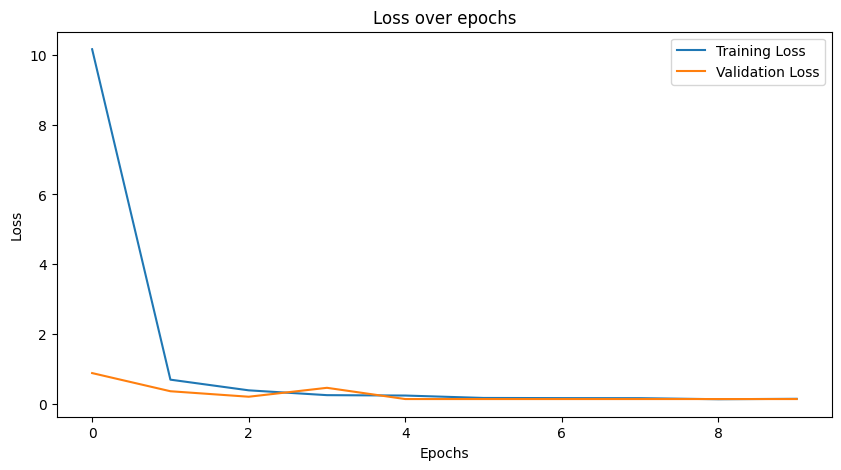

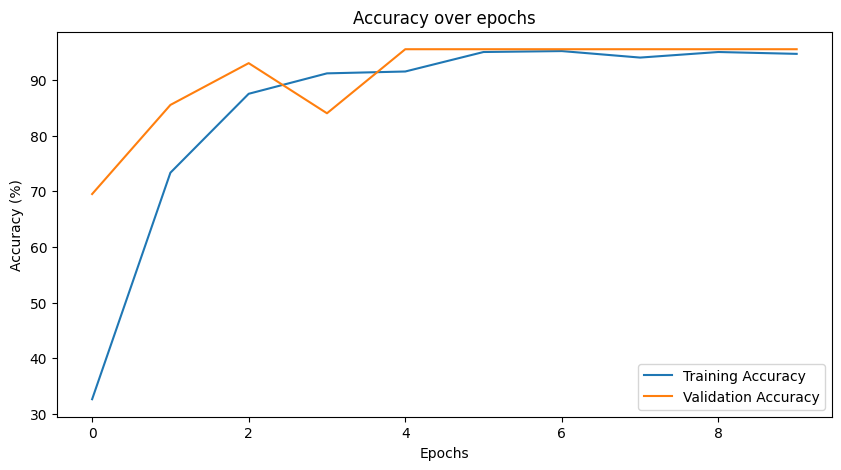

In [ ]:
#Change the optimizer learning rate to be 0.0001, batch size is 60 here
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)  # default learning rate
# Adjusts the learning rate every 5 epochs by multiplying it by 0.0001
scheduler = StepLR(optimizer, step_size=5, gamma=0.0001)
train(vgg16, train_loader, validation_loader, num_epochs=10, optimizer=optimizer, scheduler=scheduler)

analysis:Starting from Epoch 5, both the validation loss and the validation accuracy (along with the F1-score) are consistent and do not change. The model achieves a high level of performance on the validation set early on and maintains it.

##**Seventh tunning** (final tunning)

In [ ]:
# modify dropout layer with the desired dropout rate
class VGG16(nn.Module):
    def __init__(self, num_classes=4):  # Number of classes
        super(VGG16, self).__init__()
        # Load the pre-trained VGG16 model
        original_vgg16 = models.vgg16(pretrained=True)

        # Freeze the features layers (optional, remove these lines if you want to fine-tune the convolutional layers)
        for param in original_vgg16.features.parameters():
            param.requires_grad = False

        # Replace the classifier with a new one for 4 classes
        # Note: The input features of the first linear layer of the classifier might need adjustment based on the pre-trained model
        num_features = original_vgg16.classifier[0].in_features
        original_vgg16.classifier = nn.Sequential(
            nn.Linear(num_features, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.2),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.2),
            nn.Linear(4096, num_classes),
        )
        self.features = original_vgg16.features
        self.classifier = original_vgg16.classifier

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output of conv layers
        x = self.classifier(x)
        return x

# Instantiate the model
vgg16 = VGG16(num_classes=4)  # Assuming you have four classes

# Print the modified model architecture
print(vgg16)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 156MB/s]


VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [ ]:
#Change the batchsize to see if it is helpful=  32--->60
torch.manual_seed(1)

#Data agumentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # VGG16 expects 224x224 inputs
    transforms.RandomHorizontalFlip(),  # Simple augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalization
])

# Load datasets:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
# Set up data loaders:
train_loader = DataLoader(train_dataset, batch_size=60, shuffle=True)  #Shuffle is to ensure the model isn’t adapting its learning to any kind of spurious pattern


# Define transformations and normalization for your images:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the VGG model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])

val_dataset = datasets.ImageFolder(val_dir, transform=transform)
# Set up data loaders:
validation_loader = DataLoader(val_dataset, batch_size=60, shuffle=False)



Epoch 1/8
Training Loss: 9.2436, Accuracy: 35.5000%, F1-Score: 0.3523
Validation Loss: 0.7676, Accuracy: 66.5000%, F1-Score: 0.5931

Epoch 2/8
Training Loss: 0.7444, Accuracy: 72.1667%, F1-Score: 0.7172
Validation Loss: 0.2682, Accuracy: 91.0000%, F1-Score: 0.9123

Epoch 3/8
Training Loss: 0.3853, Accuracy: 87.3333%, F1-Score: 0.8742
Validation Loss: 0.1961, Accuracy: 94.5000%, F1-Score: 0.9457

Epoch 4/8
Training Loss: 0.2624, Accuracy: 89.6667%, F1-Score: 0.8970
Validation Loss: 0.3113, Accuracy: 89.0000%, F1-Score: 0.8911

Epoch 5/8
Training Loss: 0.2125, Accuracy: 92.3333%, F1-Score: 0.9232
Validation Loss: 0.1543, Accuracy: 94.0000%, F1-Score: 0.9406

Epoch 6/8
Training Loss: 0.1475, Accuracy: 95.0000%, F1-Score: 0.9498
Validation Loss: 0.1543, Accuracy: 94.0000%, F1-Score: 0.9406

Epoch 7/8
Training Loss: 0.1456, Accuracy: 94.3333%, F1-Score: 0.9434
Validation Loss: 0.1543, Accuracy: 94.0000%, F1-Score: 0.9406

Epoch 8/8
Training Loss: 0.1537, Accuracy: 93.8333%, F1-Score: 0.9384

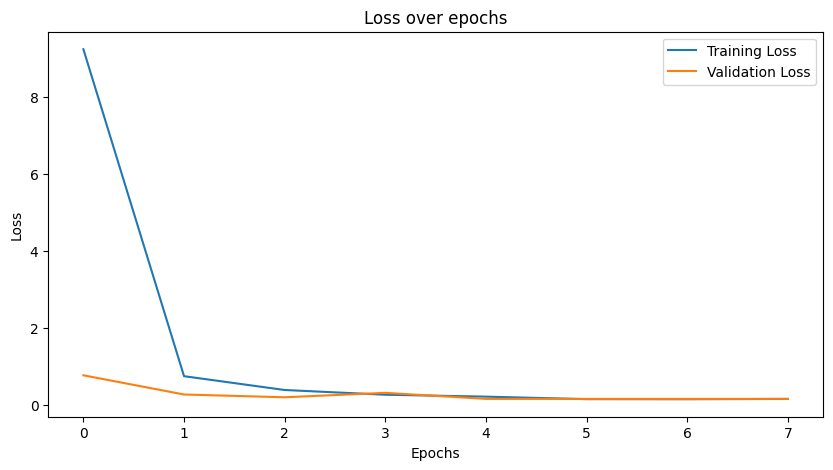

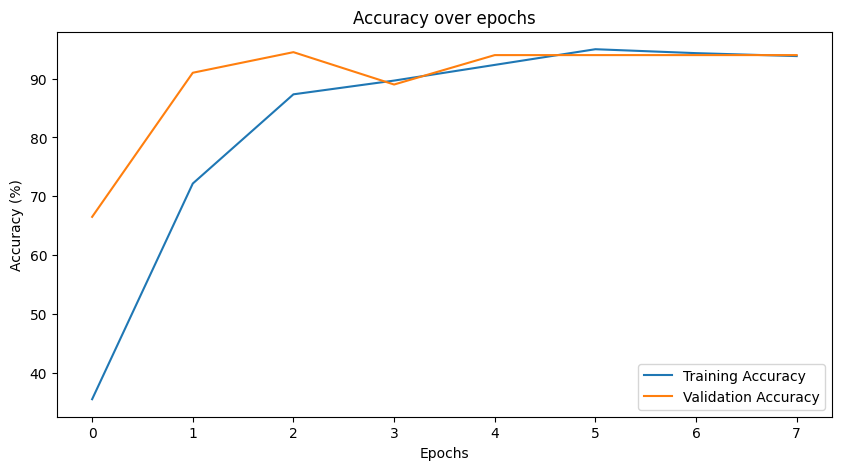

In [ ]:
#Change the optimizer learning rate to be 0.0001, batch size is 60 here
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)  # default learning rate
# Adjusts the learning rate every 5 epochs by multiplying it by 0.0001
scheduler = StepLR(optimizer, step_size=5, gamma=0.0001)
train(vgg16, train_loader, validation_loader, num_epochs=8, optimizer=optimizer, scheduler=scheduler)

#**Test Result**

###**Final Model and optimizer**

In [ ]:
# modify dropout layer with the desired dropout rate
class VGG16(nn.Module):
    def __init__(self, num_classes=4):  # Number of classes
        super(VGG16, self).__init__()
        # Load the pre-trained VGG16 model
        original_vgg16 = models.vgg16(pretrained=True)

        # Freeze the features layers (optional, remove these lines if you want to fine-tune the convolutional layers)
        for param in original_vgg16.features.parameters():
            param.requires_grad = False

        # Replace the classifier with a new one for 4 classes
        # Note: The input features of the first linear layer of the classifier might need adjustment based on the pre-trained model
        num_features = original_vgg16.classifier[0].in_features
        original_vgg16.classifier = nn.Sequential(
            nn.Linear(num_features, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.2),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.2),
            nn.Linear(4096, num_classes),
        )
        self.features = original_vgg16.features
        self.classifier = original_vgg16.classifier

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output of conv layers
        x = self.classifier(x)
        return x

# Instantiate the model
vgg16 = VGG16(num_classes=4)  # Assuming you have four classes

# Print the modified model architecture
print(vgg16)

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [ ]:
def train(model, train_loader, test_loader, num_epochs, optimizer, scheduler=None):
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Initialize the gradient scaler for mixed precision
    scaler = GradScaler()
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        total_train, correct_train, running_loss = 0, 0, 0.0
        train_preds, train_targets = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            running_loss += loss.item() * inputs.size(0)
            train_preds.extend(predicted.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train
        train_f1 = f1_score(train_targets, train_preds, average='weighted')

        if scheduler:
            scheduler.step()  # Adjust the learning rate after each epoch

        # test Phase
        model.eval()
        val_running_loss, total_val, correct_val = 0.0, 0, 0
        val_preds, val_targets = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(test_loader.dataset)
        val_accuracy = 100 * correct_val / total_val
        val_f1 = f1_score(val_targets, val_preds, average='weighted')


        #store the result of accuracy, loss
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        # Print both training and test metrics
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}%, F1-Score: {train_f1:.4f}')
        print(f'test Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}%, F1-Score: {val_f1:.4f}\n')

    #Making the plot
    # Plot training and test loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='test Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and test accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='test Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.show()

###**Collected test data result**

In [ ]:
#Change the batchsize to see if it is helpful=  32--->60
torch.manual_seed(1)
# Define transformations and normalization for your images:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the VGG model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for ImageNet
])

test_dataset = datasets.ImageFolder(test_dir_our, transform=transform)
# Set up data loaders:
test_loader = DataLoader(test_dataset, batch_size=60, shuffle=False)

Epoch 1/8
Training Loss: 8.4789, Accuracy: 35.3333%, F1-Score: 0.3492
test Loss: 0.9220, Accuracy: 67.0000%, F1-Score: 0.5798

Epoch 2/8
Training Loss: 0.7554, Accuracy: 72.6667%, F1-Score: 0.7255
test Loss: 0.4901, Accuracy: 80.5000%, F1-Score: 0.8061

Epoch 3/8
Training Loss: 0.3627, Accuracy: 87.6667%, F1-Score: 0.8769
test Loss: 0.4566, Accuracy: 84.0000%, F1-Score: 0.8442

Epoch 4/8
Training Loss: 0.2611, Accuracy: 90.6667%, F1-Score: 0.9067
test Loss: 0.7852, Accuracy: 72.5000%, F1-Score: 0.7236

Epoch 5/8
Training Loss: 0.2127, Accuracy: 92.0000%, F1-Score: 0.9202
test Loss: 0.6494, Accuracy: 81.0000%, F1-Score: 0.8113

Epoch 6/8
Training Loss: 0.1487, Accuracy: 94.0000%, F1-Score: 0.9400
test Loss: 0.6495, Accuracy: 81.0000%, F1-Score: 0.8113

Epoch 7/8
Training Loss: 0.1464, Accuracy: 95.5000%, F1-Score: 0.9552
test Loss: 0.6496, Accuracy: 81.0000%, F1-Score: 0.8113

Epoch 8/8
Training Loss: 0.1564, Accuracy: 93.6667%, F1-Score: 0.9368
test Loss: 0.6494, Accuracy: 81.0000%, F1

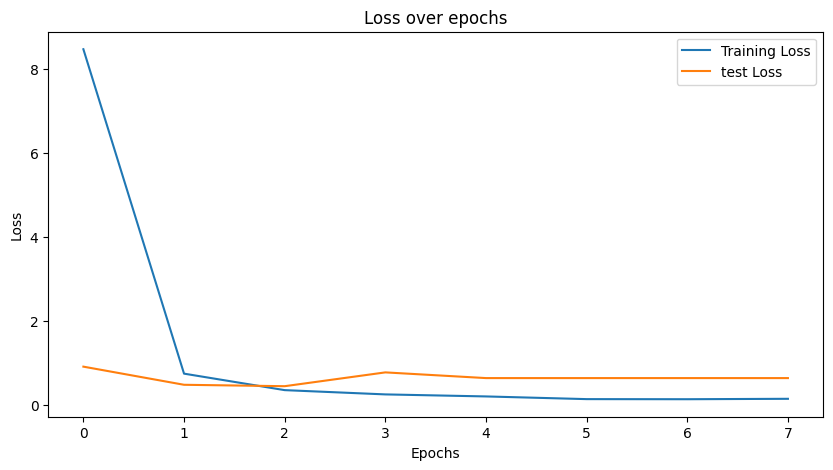

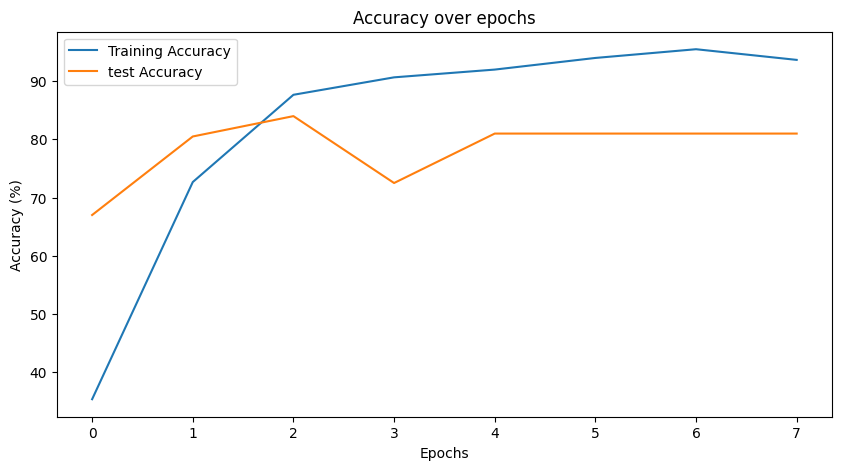

In [ ]:
#Change the optimizer learning rate to be 0.001, batch size is 60 here
optimizer = optim.Adam(vgg16.parameters(), lr=0.001)  # default learning rate
# Adjusts the learning rate every 5 epochs by multiplying it by 0.0001
scheduler = StepLR(optimizer, step_size=5, gamma=0.0001)
train(vgg16, train_loader, test_loader, num_epochs=8, optimizer=optimizer, scheduler=scheduler)

#**Confusion Matrix**

##**Accuracy, Precision, Recall, F1-Score**

In [ ]:
print(test_dataset.classes)  # This will print the list of class names corresponding to labels 0, 1, 2, 3, ...

['hazardous', 'organics', 'recycle', 'trash']


In [ ]:
y_true = []
y_pred = []
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Then can move  model to the chosen device
vgg16.to(device)
vgg16.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Turn off gradients for test, saves memory and computations
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg16(inputs)

        # Convert outputs probabilities to predicted class (0 or 1) using argmax
        _, preds = torch.max(outputs, 1)

        # Move the results back to CPU and convert them to numpy arrays if not already
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


##**Plot**

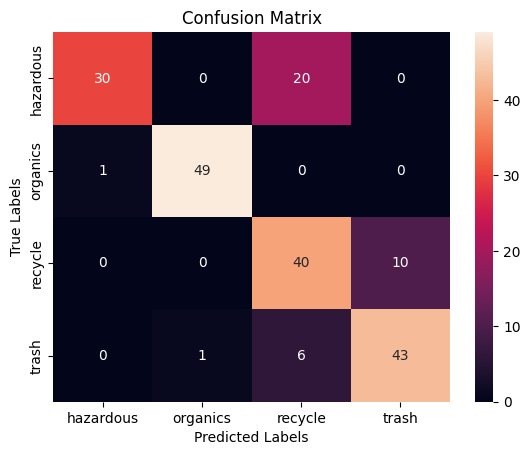

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `y_true` and `y_pred` are your true and predicted labels:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Labels')  # Set the label for the x-axis
plt.ylabel('True Labels')  # Set the label for the y-axis
# Set the tick labels on the x-axis and y-axis
plt.xticks(ticks=[0.5, 1.5, 2.5,3.5], labels=['hazardous', 'organics', 'recycle', 'trash'])
plt.yticks(ticks=[0.5, 1.5, 2.5,3.5], labels=['hazardous', 'organics', 'recycle', 'trash'])
plt.title('Confusion Matrix')
plt.show()